# Prepare Required Files and Dependencies

In [16]:
!git clone https: // github.com/dmc27/missing_pixels.git

fatal: destination path 'missing_pixels' already exists and is not an empty directory.


In [17]:
from os import listdir
from os.path import isfile

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, ReLU, BatchNormalization, add, Softmax, AveragePooling2D, \
    Dense, Input, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint

from utils import *

In [18]:
# Suppress warnings
import warnings

warnings.filterwarnings('ignore')

# Data Preparation

In [19]:
img_path = "datasets"
img_fnames = [f for f in listdir(img_path) if isfile(join(img_path, f))]
print(img_fnames[:20])

['frog.bmp', 'FOOTBALL.BMP', 'WALL.BMP', 'rooster.bmp', 'man.bmp', 'BEACH.BMP', 'airplane.bmp', 'hawaii.bmp', 'rabbits.bmp', '1fnoise.bmp', 'pelicans.bmp', 'baby.bmp', 'TABLE.BMP', 'valley.bmp', 'tank.bmp', 'baboon.bmp', 'kid.bmp', 'lily.bmp', 'bushes.bmp', 'branches.bmp', 'tulips.bmp', 'fox.bmp', 'birds.bmp', 'peppers.bmp', 'buds.bmp', 'bricks.bmp', 'FLOWERS.BMP', 'deer.bmp', 'fruits.bmp', 'desert.bmp', 'duck.bmp', 'horse.bmp', 'lena.bmp', 'sealion.bmp', 'TRAIN.BMP', 'helen.bmp', 'rainriver.bmp', 'stream.bmp', 'bark.bmp', 'SAIL.BMP', 'HOUSE.BMP', 'peak.bmp', 'PUMPKINS.BMP', 'barn.bmp', 'pony.bmp', 'bridge.bmp', 'eagle.bmp', 'barbara.bmp', 'beans.bmp', 'dune2.bmp', 'zelda.bmp', 'KIDS.BMP', 'cactus.bmp', 'sheep.bmp']


In [20]:
image_patches = []
targets = []

for img_fname in img_fnames:
    img = cv.imread(join(img_path, img_fname), cv.IMREAD_GRAYSCALE)
    img = img.astype(np.float64)

    for i in range(0, img.shape[0], BLOCK_SIZE):
        for j in range(0, img.shape[1], BLOCK_SIZE):
            patch = img[i:i + BLOCK_SIZE, j:j + BLOCK_SIZE]
            targets.append(patch[3:5, 3:5].flatten())

            patch[3:5, 3:5] = 0.0
            image_patches.append(patch)

In [21]:
X_train = np.array(image_patches) / 255.0
y_train = np.array(targets) / 255.0

In [22]:
X_train = X_train.reshape(-1, BLOCK_SIZE, BLOCK_SIZE, 1)

# Modeling

Code adaption from https://github.com/Haikoitoh/paper-implementation/blob/main/MobileNetV2.ipynb

## Architecture

In [23]:
def expansion_block(x, t, filters, block_id):
    prefix = 'block_{}_'.format(block_id)
    total_filters = t * filters
    x = Conv2D(total_filters, 1, padding='same', use_bias=False, name=prefix + 'expand')(x)
    x = BatchNormalization(name=prefix + 'expand_bn')(x)
    x = ReLU(6, name=prefix + 'expand_relu')(x)
    return x


def depthwise_block(x, stride, block_id):
    prefix = 'block_{}_'.format(block_id)
    x = DepthwiseConv2D(3, strides=(stride, stride), padding='same', use_bias=False, name=prefix + 'depthwise_conv')(x)
    x = BatchNormalization(name=prefix + 'dw_bn')(x)
    x = ReLU(6, name=prefix + 'dw_relu')(x)
    return x


def projection_block(x, out_channels, block_id):
    prefix = 'block_{}_'.format(block_id)
    x = Conv2D(filters=out_channels, kernel_size=1, padding='same', use_bias=False, name=prefix + 'compress')(x)
    x = BatchNormalization(name=prefix + 'compress_bn')(x)
    return x

In [24]:
def Bottleneck(x, t, filters, out_channels, stride, block_id):
    y = expansion_block(x, t, filters, block_id)
    y = depthwise_block(y, stride, block_id)
    y = projection_block(y, out_channels, block_id)
    if y.shape[-1] == x.shape[-1]:
        y = add([x, y])
    return y

In [25]:
def MobileNetV2(input_image=(224, 224, 3), n_classes=1000):
    input = Input(input_image)

    x = Conv2D(32, kernel_size=3, strides=(2, 2), padding='same', use_bias=False)(input)
    x = BatchNormalization(name='conv1_bn')(x)
    x = ReLU(6, name='conv1_relu')(x)

    # 17 Bottlenecks

    x = depthwise_block(x, stride=1, block_id=1)
    x = projection_block(x, out_channels=16, block_id=1)

    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=24, stride=2, block_id=2)
    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=24, stride=1, block_id=3)

    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=32, stride=2, block_id=4)
    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=32, stride=1, block_id=5)
    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=32, stride=1, block_id=6)

    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=64, stride=2, block_id=7)
    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=64, stride=1, block_id=8)
    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=64, stride=1, block_id=9)
    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=64, stride=1, block_id=10)

    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=96, stride=1, block_id=11)
    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=96, stride=1, block_id=12)
    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=96, stride=1, block_id=13)

    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=160, stride=2, block_id=14)
    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=160, stride=1, block_id=15)
    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=160, stride=1, block_id=16)

    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=320, stride=1, block_id=17)

    #1*1 conv
    x = Conv2D(filters=1280, kernel_size=1, padding='same', use_bias=False, name='last_conv')(x)
    x = BatchNormalization(name='last_bn')(x)
    x = ReLU(6, name='last_relu')(x)

    #AvgPool 7*7
    x = GlobalAveragePooling2D(name='global_average_pool')(x)

    output = Dense(n_classes, activation='sigmoid')(x)

    model = Model(input, output)

    return model

In [28]:
model_fname = "models/model.mobilenet.h5"

model = MobileNetV2((BLOCK_SIZE, BLOCK_SIZE, 1), NUM_OUT_NODES)

model.compile(loss="mean_squared_error", optimizer="adam",
              metrics=["accuracy"])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 8, 8, 1)]            0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 4, 4, 32)             288       ['input_2[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 4, 4, 32)             128       ['conv2d_1[0][0]']            
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 4, 4, 32)             0         ['conv1_bn[0][0]']      

## Training

In [29]:
checkpoint = ModelCheckpoint(model_fname, monitor='loss', verbose=1,
                             save_best_only=True)
callbacks_list = [checkpoint]

history = model.fit(X_train, y_train, epochs=100, batch_size=256,
                    validation_split=0.1, callbacks=callbacks_list)

Epoch 1/450


2023-07-20 12:11:32.732252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


195/195 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.2713

2023-07-20 12:11:47.744770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: loss improved from inf to 0.01031, saving model to models/model.mobilenet.h5
195/195 [==============================] - 17s 58ms/step - loss: 0.0103 - accuracy: 0.2713 - val_loss: 0.0386 - val_accuracy: 0.2421
Epoch 2/450
195/195 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.3021
Epoch 2: loss improved from 0.01031 to 0.00537, saving model to models/model.mobilenet.h5
195/195 [==============================] - 8s 42ms/step - loss: 0.0054 - accuracy: 0.3021 - val_loss: 0.0390 - val_accuracy: 0.2421
Epoch 3/450
195/195 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.3215
Epoch 3: loss improved from 0.00537 to 0.00478, saving model to models/model.mobilenet.h5
195/195 [==============================] - 9s 44ms/step - loss: 0.0048 - accuracy: 0.3215 - val_loss: 0.0378 - val_accuracy: 0.2421
Epoch 4/450
195/195 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.3343
Epoch 4: loss improved from 0.00478 to 0.0045

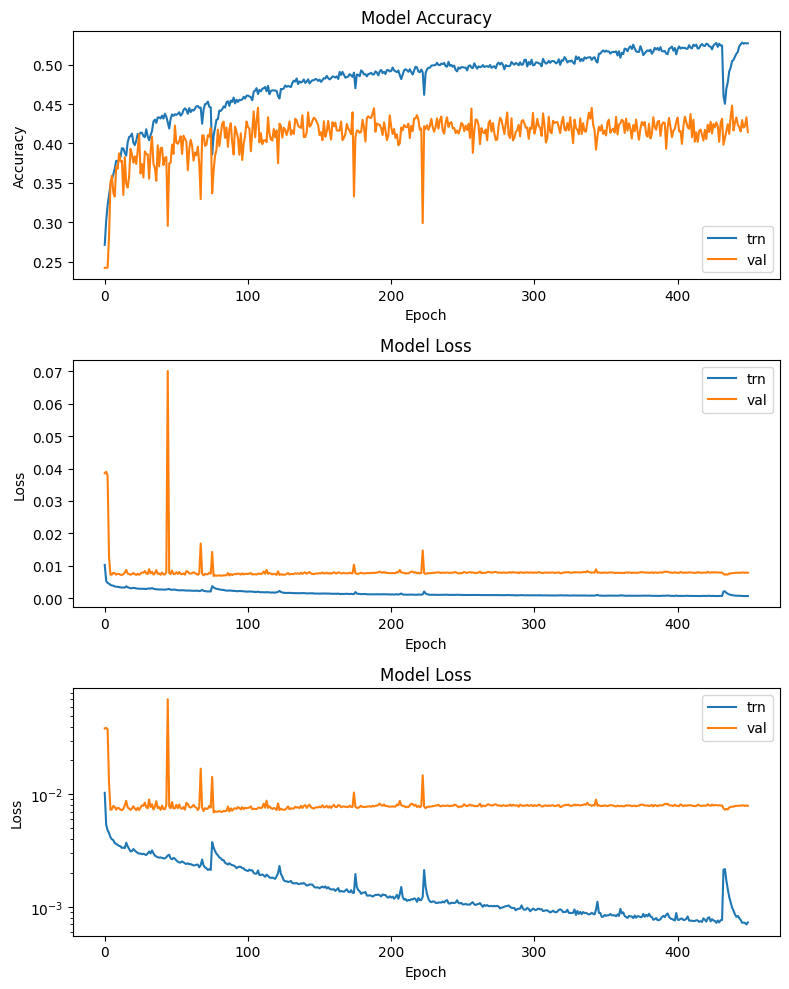

In [30]:
plot_training_history(history)

2023-07-20 13:10:51.724019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 8ms/step
MSE = 15.22


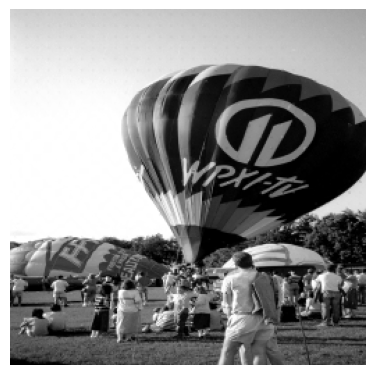

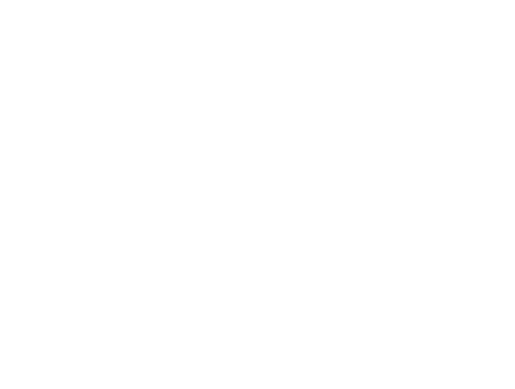

In [31]:
evaluate_cnn(model)